In [1]:
pip install opencv-python

In [2]:
pip install cmake

In [3]:
pip install dlib

In [4]:
# 모듈 불러오기

import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib 
import math

print("done")

done


In [5]:
# 모델 불러오기

model_path = '/content/drive/MyDrive/Colab/ca_st/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
# 저장한 landmark 모델 불러오기
# landmark_predictor는 rgb이미지와 dlib.rectangle을 입력받아
# dlib.full_object_detection 를 반환

print("done")

done


# 첫번째 시도 - 노드 따라가기

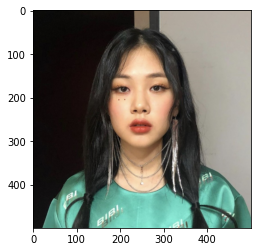

In [6]:
# 테스트 1번 비비고양이 불러오기

my_image_path = '/content/drive/MyDrive/Colab/ca_st/images/bibi.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (500, 500))    # 500x500의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 저장

# 색상 전환해서 확인
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #BRG를 RGB로
plt.imshow(img_rgb)
plt.show()

In [7]:
# 얼굴 인식 함수 만들기

detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
# dlib.rectangles 타입의 객체를 반환
# dlib.rectangles 는 dlib.rectangle 객체의 배열 형태
# dlib.rectangle객체는 left(), top(), right(), bottom(), height(), width() 등을 포함

dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
# 이미지 unsampling 방법을 통해 크기를 키우는 것을 이미지피라미드라고 함

print(dlib_rects)

rectangles[[(167, 133) (322, 288)]]


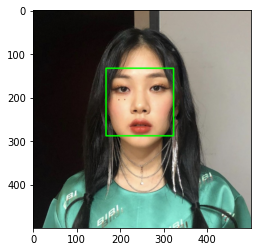

In [8]:
for dlib_rect in dlib_rects: # dlib.rectangle 에 포함된 데이터를 저장
    l = dlib_rect.left() # 왼쪽 끝
    t = dlib_rect.top() # 위쪽 끝
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
# 정사각형이 그려진 파일 저장

plt.imshow(img_show_rgb)
plt.show()

In [9]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

# points의 값들을 parts() 함수로 꺼내서 (x,y)형태로 접근할 수 있도록 변환
# 따라서 list_points 에는 tuple(x,y)로 68개로 이루어진 리스트가 원소가 됨
# 이미지에서 찾아진 얼굴 개수마다 반복하면 
# list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장된다 

print('얼굴', len(list_landmarks),'개,', '랜드마크', len(list_landmarks[0]), '개')

얼굴 1 개, 랜드마크 68 개


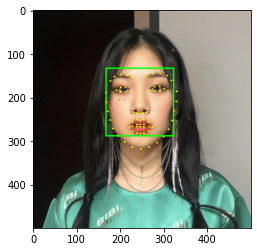

In [10]:
# 랜드마크를 영상에 출력

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

조원들끼리 얘기 중에 이 부분에서 list_points 에 관한 의문이 나왔었다.

list_points를 이용하면 한 명의 얼굴만 읽을 수 있는게 아닌가 하는 얘기였는데

이후 여러명의 얼굴을 시도해 볼 예정

In [11]:
# (x,y) 코의 중심점
# (w,h) 스티커의 크기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

# 랜드마크 30을 기준점으로 잡기

(244, 220)
(x,y) : (244,220)
(w,h) : (156,156)


In [12]:
# 위에서 계산한 크기로 스티커 resize

sticker_path = '/content/drive/MyDrive/Colab/ca_st/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(156, 156, 3)


In [13]:
# 이미지의 좌표 조정
# 스티커 이미지 정중앙보다 약간 왼쪽 위에 고양이 코가 있으므로
# 사진상의 코와 스티커의 정중앙을 맞춰주자

refined_x = int(x - w//2.05)       # left
refined_y = int(y - w//2.1)       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (168,146)


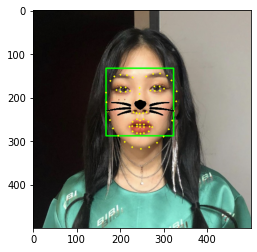

In [14]:
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지
# 흰색이 아닌 검은색 코와 수염 부분만 스티커로 사용하기 위해
# np.where를 통해 img_sticker 가 255 인 부분은 sticker_area를 사용하고
# 255가 아닌 부분을 img_sticker를 사용해서 img_show 에 다시 적용

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

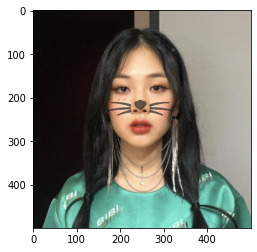

In [15]:
# bounding box와 landmark를 제거하기 위해 원본을 불러와서 최종 결과만 출력

sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area, cv2.addWeighted(img_sticker, 0.6, sticker_area, 0.4, 0)).astype(np.uint8)
# cv2.addWeighted 를 사용해서 투명도 조절

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 두번째 시도 - 여러 명이라면 어떨까?

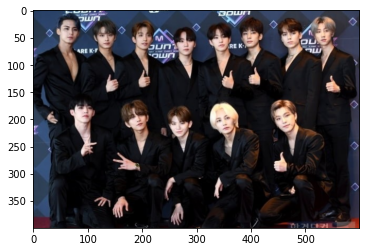

In [16]:
# 테스트 2번 고양이 떼거지 불러오기

my_image_path = '/content/drive/MyDrive/Colab/ca_st/images/17.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (600, 400))    # 600x400의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 저장

# 색상 전환해서 확인
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #BRG를 RGB로 바꿔서 저장
plt.imshow(img_rgb)
plt.show()

rectangles[[(49, 22) (85, 58)], [(441, 186) (477, 222)], [(333, 190) (369, 226)], [(249, 198) (285, 234)], [(377, 30) (413, 66)], [(77, 166) (113, 202)], [(185, 34) (221, 70)], [(261, 46) (297, 82)], [(173, 182) (209, 218)], [(453, 34) (489, 70)], [(113, 34) (149, 70)], [(325, 38) (361, 74)], [(513, 26) (549, 62)]]


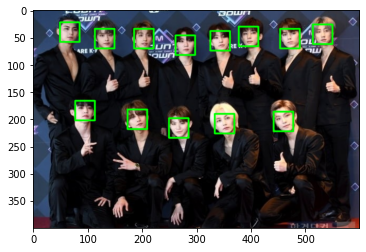

In [17]:
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
# 비비에서 만든 함수 그대로 사용

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects: # dlib.rectangle 에 포함된 데이터를 저장
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
# 정사각형이 그려진 파일 저장

plt.imshow(img_show_rgb)
plt.show()

# 얼굴이 많아서 박스도 여러개 생긴다

In [18]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print('얼굴', len(list_landmarks),'개,', '랜드마크', len(list_landmarks[0]), '개')

얼굴 13 개, 랜드마크 68 개


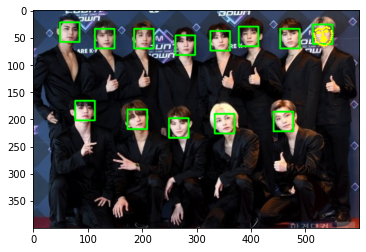

In [19]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

첫번째 시도와 동일하게 적용하였더니 얼굴 하나만 랜드마크를 읽어온다.

for 문을 한번 더 사용하여 list_lnadmarks의 모든 얼굴을 순회하도록 만듬


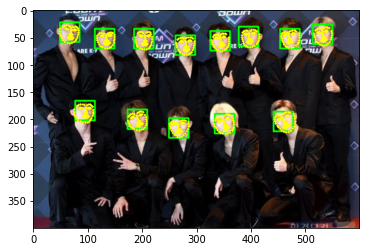

In [20]:
for landmark in list_landmarks:
    for i in range(len(list_landmarks)):
        for idx, point in enumerate(list_landmarks[i]):
            cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

plt.imshow(img_show_rgb)
plt.show()

In [21]:
# (w,h) 스티커의 크기는 for문과 무관하므로 미리 변수를 정리 했지만 ...

w = dlib_rect.width()
h = dlib_rect.width()

# 스티커를 위에서 계산한 크기로 resize
img_sticker = cv2.imread(sticker_path) # sticker_path 그대로 사용
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)
 # 얼굴 사이즈가 비슷비슷해서 이렇게 하긴 했는데
 # 원래는 for문 안에 들어가서 얼굴마다 스티커 사이즈가 달라야 하는것 아닌가 싶다

(37, 37, 3)


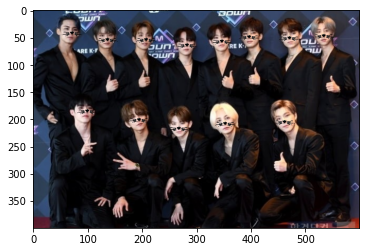

In [22]:
# 얼굴마다 스티커 붙여주기
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    refined_x = int(x - w//2.1)      # left
    y = landmark[30][1]
    refined_y = int(y - w//2.1)      # top

# bounding box와 landmark가 없는 원본을 불러와서 바로 최종 결과만 출력
    sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 세번째 시도 - 고개를 돌리면 어떡하지?

원근감을 살려서 회전시킬 수 있는 함수를 찾아봄

삼각형을 기준으로 이동시키는 AffineTransform 과

사각형을 기준으로 이동시키는 PerspectiveTransform 두가지를 찾았는데

AffineTransform은 원근감이 없어서 PerspectiveTransform 으로 결정

![](https://gaussian37.github.io/assets/img/vision/concept/geometric_transformation/10.png)
이미지 출처 : [https://gaussian37.github.io/vision-concept-geometric_transformation](https://gaussian37.github.io/vision-concept-geometric_transformation/)


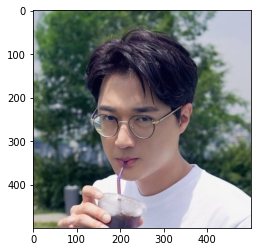

In [23]:
# 고개를 살짝 돌린 사진 가져오기

my_image_path = '/content/drive/MyDrive/Colab/ca_st/images/jang.jpeg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (500, 500))    # 500x500의 크기로 Resize
img_org = img_bgr.copy()
img_show = img_bgr.copy()      #- 출력용 이미지 별도 저장

# 색상 전환해서 확인
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) #BRG를 RGB로
plt.imshow(img_rgb)
plt.show()

rectangles[[(118, 201) (304, 387)]]


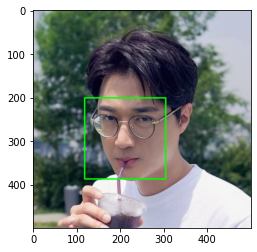

In [24]:
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
# 비비에서 만든 함수 그대로 사용

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects: # dlib.rectangle 에 포함된 데이터를 저장
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
# 정사각형이 그려진 파일 저장

plt.imshow(img_show_rgb)
plt.show()

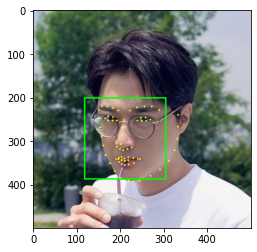

In [25]:
list_landmarks = [] # 랜드마크 찾기
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks: # 랜드마크를 사진에 출력
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [26]:
# (x,y) 코의 중심점 // 위의 경우와 다르게 29번을 중심으로 잡음 
# (w,h) 스티커의 크기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[29]) # nose center index : 29
    x = landmark[29][0]
    y = landmark[29][1]
    w = dlib_rect.width()
    h = dlib_rect.width()

img_sticker = cv2.imread(sticker_path) # sticker_path 그대로 사용
img_sticker = cv2.resize(img_sticker, (w,h))
sticker_copy = img_sticker.copy()
print (img_sticker.shape)

(204, 288)
(187, 187, 3)


좌표를 2가지로 구분

첫번째는 이미지 캔버스의 좌표$(x_i,y_i)$로 불러온 사진의 left top을 원점으로 하는 좌표고

두번째는 스티커 캔버스의 좌표$(x_s,y_s)$로 스티커의 left top을 원점으로 하는 좌표

스티커 캔버스의 원점은 이미지 캔버스의 원점에서 $(l,t)$ 만큼 떨어져있으므로

스티커 캔버스의 좌표를 이미지 캔버스 위에 나타내려면

$(x_i,y_i) = (x_s+l,y_s+t)$ 로 나타낼 수 있고,

반대로 이미지 캔버스의 좌표를 스티커 캔버스에 나타내려면

$(x_s,y_s) = (x_i-l,y_i-t)$ 로 나타낼 수 있다.

![](https://images.velog.io/images/yvelog/post/a013ce92-93e6-4f6f-b55f-56ffd5df2215/SmartSelect_20210723-120338_Samsung%20Notes.jpg)

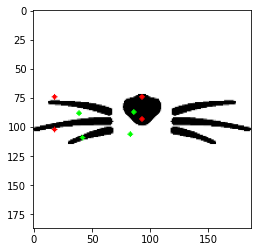

In [27]:
# 스티커의 기준점이 될 좌표 찾기
# cat_list1 = [(93, 72), (20, 75), (20, 102), (93, 108)] 노가다로 좌표를 찾았던 흔적
cat_list1 = [(w//2, int(w*0.4)), (int(w*0.1), int(w*0.4)), (int(w*0.1), int(w*0.55)), (w//2, w//2)]
# 이동해 가야 할 좌표 찾기
cat_list2 = [(landmark[29][0] - l, landmark[29][1] - t),
             (landmark[2][0] - l, landmark[2][1] - t),
             (landmark[3][0] - l, landmark[3][1] - t),
             (landmark[30][0] - l, landmark[30][1] - t)]

# 그림으로 확인 빨강: 기준점, 초록: 변환된 점
for point in cat_list1:
    cv2.circle(sticker_copy, point, 2, (255, 0, 0), -1)
for point in cat_list2:
    cv2.circle(sticker_copy, point, 2, (0, 255, 0), -1)

plt.imshow(sticker_copy)
plt.show()

투영변환 함수를 사용할 예정이라

변환시켜줄 사각형 기준점을 잡고 이동해 가야하는 점을 확인

투영변환은 비뚤게 찍은 명함이나 서류 등을 똑바로 세우는 기능을 함!

여기서는 반대로 바르게 서있는 수염을 비틀 것.

이동은 스티커캔버스 내에서 하므로 스티커 캔버스의 좌표가 필요하지만

우리가 구할 수 있는 랜드마크의 좌표는 이미지 캔버스의 좌표이므로 변환을 해야 함.

$\begin{cases} x_s = x_i-l \\ y_s= y_i-t \end{cases}$ 이 계산을 해준게 cat_list2

고양이 코는 사람 코에 얹어지게 29, 30번쪽으로 이동시키고

수염 두개는 볼의 랜드마크를 기준으로 이동시킴

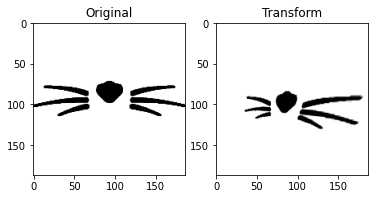

In [28]:
# 변환과정
pts1 = np.float32(cat_list1) # 이동 전 스티커의 좌표
pts2 = np.float32(cat_list2) # 이동 후 스티커의 좌표
M = cv2.getPerspectiveTransform(pts1,pts2) # 변환시켜주는 매트릭스
dst = cv2.warpPerspective(img_sticker,M,(w,h), borderValue = [255, 255, 255, 255]) 
      # 실제로 이미지를 M을 이용해 변환해주는 코드
      # 회전시켰을 때 검은 배경을 없애기 위해 borderValue 설정

plt.subplot(121),plt.imshow(img_sticker),plt.title('Original')
plt.subplot(122),plt.imshow(dst,),plt.title('Transform')
plt.show()


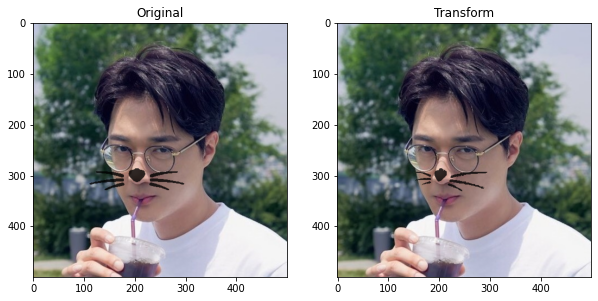

In [29]:
# 이미지의 좌표 조정
# 29번 점을 x, y로 설정했고, 코의 point를 x,y 에 붙여줄 예정

refined_x = int(x - cat_list2[0][0])       # left
refined_y = int(y - cat_list2[0][1])       # top

# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지
# 흰색이 아닌 검은색 코와 수염 부분만 스티커로 사용하기 위해
# np.where를 통해 img_sticker 가 0 인 부분은 배경 이미지를 사용하고
# 0이 아닌 부분을 sticker_area를 사용해서 img_show 에 다시 적용
# cv2.addWeighted 를 사용해서 투명도 조절

# 변환 전 좌표 이동만 한 경우
sticker_area1 = img_org[int(y - cat_list1[0][1]):int(y - cat_list1[0][1])+img_sticker.shape[0], int(x - cat_list1[0][0]):int(x - cat_list1[0][0])+img_sticker.shape[1]]
img_org[int(y - cat_list1[0][1]):int(y - cat_list1[0][1])+img_sticker.shape[0], int(x - cat_list1[0][0]):int(x - cat_list1[0][0])+img_sticker.shape[1]] = \
    np.where(img_sticker==0, cv2.addWeighted(img_sticker, 0.8, sticker_area1, 0.2, 0), sticker_area1).astype(np.uint8)

# 변환시켜준 경우
sticker_area2 = img_bgr[refined_y:refined_y+dst.shape[0], refined_x:refined_x+dst.shape[1]]
img_bgr[refined_y:refined_y+dst.shape[0], refined_x:refined_x+dst.shape[1]] = \
    np.where(dst==0, cv2.addWeighted(dst, 0.8, sticker_area2, 0.2, 0), sticker_area2).astype(np.uint8)


plt.figure(figsize=(10, 10))
plt.subplot(121),plt.imshow(cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)),plt.title('Original')
plt.subplot(122),plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)),plt.title('Transform')

plt.show()

똑같은 코드에 반대쪽 회전 사진을 집어넣은 결과

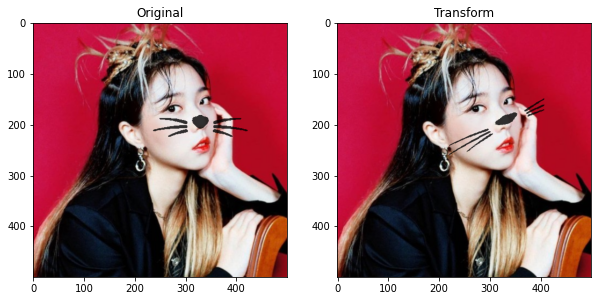

똑같은 코드에 정면 사진을 집어넣은 결과

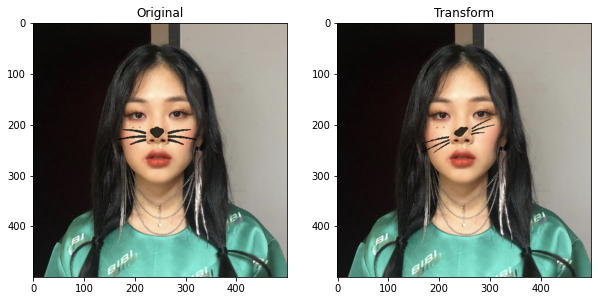

볼 윤곽선을 기준으로 하는 회전은 너무 민감하게 회전하는 것을 느낌

그리고 사진마다 적당한 형태로 만들어주기 위해

일일히 좌표를 설정하는 것이 부적합 하다고 판단

(위의 두 사진도 좌표를 적당히 조절하면 멀쩡해보였다..)

# 네번째 시도 - 모든 각도를 포용하려면?

새로 좌표를 설정하는 과정에서 고려한 부분
- 주어진 랜드마크로 쉽게 지정할 수 있을 것
- 얼굴을 회전해도 크게 변하지 않는 지점일 것
  - 얼굴 윤곽선은 말 그대로 윤곽이므로, 얼굴 회전 시 나타내는 지점이 너무 달라서 쓸 수가 없음
    - 예를 들어 정면에서는 관자놀이를 가리키던 점이 측면에서는 귀를 가리키는 식
    - 윤곽선을 이용한 기준을 잡았더니, 정면사진에서도 수염이 비틀어지는 경우가 발생.
    - 강남캠의 지은님께서 눈썹각도 = 수염각도 를 이용하신 것처럼 좀 더 수염 모양과 연관성있는 형태를 찾아야함
  - 하지만 눈썹을 기준으로 변환할 경우 스티커의 위치 잡기가 힘들어짐
  - 그래서 코를 선택
- 이동해도 사각형 형태를 유지하는 좌표일 것
  - 여기서 초반에 문제가 많이 생겼던게, '볼 윤곽선과 코의 중점' 같은 기준에서는 상황에 따라 좌표가 뒤집어져서 수염이 꼬여버림
  - 따라서 회전에 영향을 덜 받는 코를 중심으로 사각형을 잡음
  - 코를 이등변삼각형으로 생각하고, 중간을 잘라낸 등변사다리꼴 형태
    - 아래에도 언급하겠지만 이런 형태로 잡았더니 왜인지 상하 회전에는 취약해졌~~고 고칠방법을 모르겠~~다

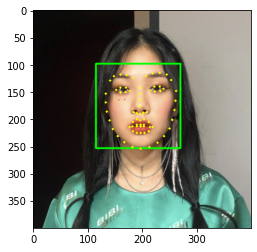

In [30]:
my_image_path = '/content/drive/MyDrive/Colab/ca_st/images/bibi.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (400,400))    # 400x400의 크기로 Resize 앞보다 사이즈를 줄였다
img_org = img_bgr.copy()
img_show = img_bgr.copy()      #- 출력용 이미지 별도 저장
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # 색변환시켜서 저장

dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)
# 비비에서 만든 함수 그대로 사용

for dlib_rect in dlib_rects: # dlib.rectangle 에 포함된 데이터를 저장
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
# 정사각형이 그려진 파일 저장

list_landmarks = [] # 랜드마크 찾기
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

for landmark in list_landmarks: # 랜드마크를 사진에 출력
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

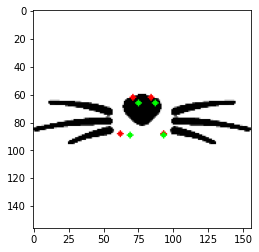

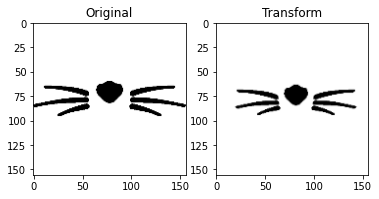

In [31]:
# 오리지날을 위한 기준점 (변환하는 사진에서는 x,y를 쓰지 않기로 함)
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[29][0]
    y = landmark[29][1]
    w = dlib_rect.width()
    h = dlib_rect.width()

# 스티커 resize
img_sticker = cv2.imread(sticker_path) # 앞서 사용한 스티커 그대로
img_sticker = cv2.resize(img_sticker, (w,h))
sticker_copy = img_sticker.copy()

# 스티커의 기준점이 될 좌표 찾기
cat_list1 = [(int(w*0.46), int(w*0.4)),
             (int(w*0.54), int(w*0.4)),
             (int(w*0.4), int(w*0.57)),
             (int(w*0.6), int(w*0.57))]
# 이동해 가야 할 좌표 찾기
cat_list2 = [((landmark[31][0]+landmark[27][0])//2 - l, (landmark[31][1]+landmark[27][1])//2 - t),
             ((landmark[35][0]+landmark[27][0])//2 - l, (landmark[35][1]+landmark[27][1])//2 - t),
             (landmark[31][0] - l, landmark[31][1] - t),
             (landmark[35][0] - l, landmark[35][1] - t)]

# 그림으로 확인 빨강: 기준점, 초록: 변환된 점
for point in cat_list1:
    cv2.circle(sticker_copy, point, 2, (255, 0, 0), -1)
for point in cat_list2:
    cv2.circle(sticker_copy, point, 2, (0, 255, 0), -1)

plt.imshow(sticker_copy)
plt.show()

# 변환과정
pts1 = np.float32(cat_list1)
pts2 = np.float32(cat_list2)
M = cv2.getPerspectiveTransform(pts1,pts2) # 변환시켜주는 매트릭스
dst = cv2.warpPerspective(img_sticker,M,(w,h), borderValue = [255, 255, 255, 255])
      # 실제로 이미지를 M을 이용해 변환해주는 코드
      # 회전시켰을 때 검은 배경을 없애기 위해 borderValue 설정

plt.subplot(121),plt.imshow(img_sticker),plt.title('Original')
plt.subplot(122),plt.imshow(dst,),plt.title('Transform')
plt.show()

좌표가 좀 복잡해졌는데..

코의 모양을 기준으로 사다리꼴을 형성해서 회전에 너무 예민하지 않도록 해봄

휙휙 돌아가지 않도록 볼 대신 코의 좌표만으로 위치를 잡아으면 휙휙 돌아가지 않을 것 같았다



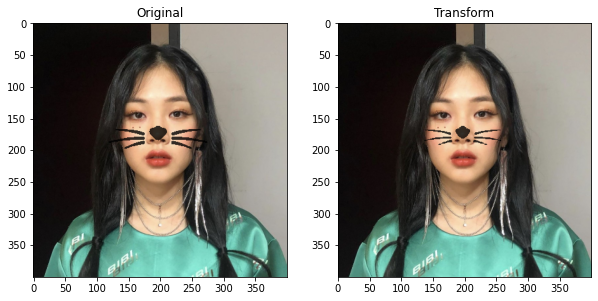

In [32]:
# 이미지의 좌표 조정
# 29번 점을 x, y로 설정했고
# 위쪽 빨간 점 2개의 중점이 랜드마크의 29번 자리에 붙을 수 있게 함
refined_x = x - (cat_list1[0][0]+cat_list1[1][0])//2      # left
refined_y = y - (cat_list1[0][1]+cat_list1[1][1])//2      # top

# 변환 전 좌표 이동만 한 경우
sticker_area1 = img_org[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_org[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0, cv2.addWeighted(img_sticker, 0.8, sticker_area1, 0.2, 0), sticker_area1).astype(np.uint8)

# 변환시켜준 경우
    # 굳이 x 를 기준으로 한 공간을 잡을 이유가 없을 것 같아서
sticker_area2 = img_bgr[t:t+dst.shape[0], l:l+dst.shape[1]]
    # 스티커가 들어갈 공간 = l과 t 에서 스티커 가로세로만큼 확보
img_bgr[t:t+dst.shape[0], l:l+dst.shape[1]] = \
    np.where(dst==0, cv2.addWeighted(dst, 0.8, sticker_area2, 0.2, 0), sticker_area2).astype(np.uint8)
    # 똑같은 사이즈로 만들고 검은색 수염인 경우만 드러나도록 설정

plt.figure(figsize=(10, 10))
plt.subplot(121),plt.imshow(cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)),plt.title('Original')
plt.subplot(122),plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)),plt.title('Transform')

plt.show()

똑같은 코드에 사진만 다르게 불러와서 작업한 결과

![](https://media.vlpt.us/images/yvelog/post/d8086422-c05f-45a2-8e8d-5c470ee6df15/image.png)
![](https://media.vlpt.us/images/yvelog/post/ec2ca69b-7f63-4fcd-8efd-992d01f3176b/image.png)
![](https://media.vlpt.us/images/yvelog/post/c38f2004-cb8d-43f1-ab1b-e96aa71f3149/image.png)
![](https://media.vlpt.us/images/yvelog/post/6428a737-d775-474e-8053-be0032772d4f/image.png)


# 결론

정면 사진과 측면 사진을 동시에 만족시킬만 한 결과물을 만들지는 못했다 ㅠㅠ

네번째 시도에서 적당한 모양새가 나오기는 했지만

수염의 원근감이 죽어버려서 단순히 회전한 것과 비슷한 형태가 되어버림

코를 기준으로 양쪽의 범위를 똑같이 잡은 탓이라 생각하고

비대칭적인 사각형도 잡아보고, 사다리꼴도 잡아보고

변들이 평행하지 않은 사각형도 만들어보았으나 

코를 축으로 양쪽이 대칭이 아니라면 정면에서 고장나고

(정면이라고 해도 랜드마크가 완벽히 정면처럼 찍히지 않고 약간씩 비틀어지므로)

대칭으로 잡으면 원근감이 사라져서 측면의 모양이 이쁘지 않다..



## 아쉬운 점

- y축 회전은 어느정도 커버가 되는데 x축 회전에서는 바보가 되어버림
- 여러명에게 동시에 적용시킬 수도 있을 것 같은데 for 문에 저 내용을 다 집어넣기에는 아직 코드 작성 기술이 미숙함
- 변환 시켰을때 수염이 캔버스 밖으로 나가면서 잘리는 현상은 
cv2.warpPerspective에서 (w,h)를 조정해주면 될 것 같긴 한데
이후 스티커 공간에 붙이는 과정에서 처리를 못할 것 같아서 포기했고..
- 좀 더 얼굴 곡면에 달라붙는 느낌을 원했는데 그건 반쪽만 가지고 변환을 시켰을 때 훨씬 더 잘 나타났지만 그렇게 하면 정면 사진이 완전 고장나버려서.. 둘 다 커버할 수 있는 방법을 찾고 싶었지만 실패...

마지막까지 여러 좌표를 잡아서 시도해보았으나

이건 이렇게 주먹구구식으로 노가다를 할 게 아니고,

좀 더 얼굴 골격에 관한 이해를 바탕으로 설정해야 하는게 아닌가 싶다

이번 노드를 작업하면서 가장 크게 느낀 점은

노드 내용과는 전혀 상관 없는 버전관리의 중요성....

그때그때 내키는 대로 파일을 열어서 작업했더니

저번에 했던거 다시 해보고 싶은데? 하면 그 때의 세팅을 다시 쌓아가야 해서...

다음 부터는 좀 더 버전을 잘 나눠서 유연하게 대처할 수 있게 연습해야겠다
